# Changing backbone to RNN
### First, setup libraries

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
tensorboard = SummaryWriter()

### Load datasets in sequence

##### Define resizing method

In [2]:
transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    transforms.Resize((70, 210)),

    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
])

##### Define a method to calculate the overall traversal_cost of a image which contains several crops

In [3]:
def calculate_overall_cost(arr):
    if len(arr) == 1:
        # if only one entry, it takes up 100% weight
        return arr[0]
    elif len(arr) == 2:
        # if only two entries, first entry takes up 70% and second entry takes up 30%
        adjusted_weights = np.array([0.7, 0.3])
        return np.average(arr, weights=adjusted_weights)
    else:
        # if there are more than two entries, apply the custom weights
        if arr[0] >= max(arr[1:]):
            # if the first entry is the largest, it takes up 100% weight
            return arr[0]
        else:
            # apply the custom weights: 50% to first entry, 30% to second entry, and 20% to third entry
            adjusted_weights = np.array([0.5, 0.3, 0.2])
            total_weight = adjusted_weights.sum()
            adjusted_weights = (adjusted_weights / total_weight) * len(arr)
            return np.average(arr, weights=adjusted_weights)

##### Define dataset loading method for sequence

In [4]:
class TraversabilityCostDataset(Dataset):
    def __init__(self, data_path, metadata_path, seq_len, transform):
        self.data_path = data_path
        self.metadata_path = metadata_path
        self.seq_len = seq_len

        # Load the metadata
        self.metadata = pd.read_csv(metadata_path)

        # Group the crops by trajectory ID
        self.trajectories = self.metadata.groupby('trajectory_id')['crop_id'].apply(list).to_dict()

        # Sort the trajectory IDs
        self.trajectory_ids = sorted(list(self.trajectories.keys()))

        self.transform = transform

    def __len__(self):
        return len(self.trajectory_ids)

    def __getitem__(self, idx):
        # Get the trajectory ID for the current item
        traj_id = self.trajectory_ids[idx]

        # Load the crops and traversal costs for the current trajectory
        crop_ids = self.trajectories[traj_id][:self.seq_len]
        crops = []
        for crop_id in crop_ids:
            image = Image.open(os.path.join(self.data_path, f'{crop_id:05d}.png')).convert('RGB')
            crops.append(image)

        if self.transform:
            crops = [self.transform(crop) for crop in crops]

        traversal_costs = self.metadata[self.metadata['trajectory_id'] == traj_id].sort_values('image_timestamp')['traversal_cost'].to_numpy()[:self.seq_len]
        overall_cost = calculate_overall_cost(traversal_costs)

        # Pad the sequence with zero-filled tensors if it is too short
        if len(crops) < self.seq_len:
            num_padding = self.seq_len - len(crops)
            pad_tensor = torch.zeros_like(crops[0])
            crops += [pad_tensor] * num_padding

        # Return the crops and overall cost as tensors
        return torch.stack(crops), overall_cost

### GPU?

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



### Design a simple RNN

In [6]:
class TraversabilityCostGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TraversabilityCostGRU, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.gru2 = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.gru1(x)
        output, _ = self.gru2(output)
        output = self.fc(output[:, -1, :])
        return output

In [7]:
# Define the loss function
criterion = nn.MSELoss()

# Initialize the model

input_size = 70*210*3  # Crop image channels
hidden_size = 256  # LSTM hidden size
num_layers = 2 # Number of LSTM layers
output_size = 1  # Regression output size

model = TraversabilityCostGRU(input_size, hidden_size, num_layers, output_size).to(device)

# Get all the parameters of the new model
base_params = model.parameters()

print(model)

TraversabilityCostGRU(
  (gru1): GRU(44100, 256, num_layers=2, batch_first=True)
  (gru2): GRU(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [8]:
# Create data loaders
seq_len = 3
train_dataset = TraversabilityCostDataset('./datasets/data/images_train', './datasets/data/new_train.csv', seq_len=seq_len, transform=transform)
test_dataset = TraversabilityCostDataset('./datasets/data/images_test', './datasets/data/new_test.csv', seq_len=seq_len, transform=transform)
val_dataset = train_dataset
train_size = 70/(100-15)
train_indices, val_indices = train_test_split(range(len(train_dataset)), train_size=train_size)
# Extract the corresponding subsets of the train dataset
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

### Training loop

In [9]:
# Define hyperparameters
optimizer = optim.SGD(model.parameters(), lr=1e-3)
batch_size = 16
num_epochs = 100

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

In [11]:
# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0
loss_values = torch.zeros(2, num_epochs)

# Train model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")

    # Loop over the training batches
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader_pbar):

        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")

        # Move images and traversal scores to GPU (if available)
        batch_x = batch_x.to(device)
        batch_y = batch_y.type(torch.FloatTensor).to(device)

        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()

        # Perform forward pass        
        output = model(batch_x.view(batch_size, seq_len, input_size))

        # Compute loss 
        # nn.MSELoss() (and other PyTorch loss functions) is the average loss over the batch.
        loss = nn.MSELoss()(output.squeeze(), batch_y.float())

        # Perform backpropagation (update weights)
        loss.backward()

        # Adjust parameters based on gradients
        optimizer.step()
        # Accumulate batch loss to average over the epoch        
        train_loss += loss.item() * batch_x.size(0)

        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
    # Validation
    val_loss = 0.

    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()

    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")

    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for batch_idx, (batch_x, batch_y) in enumerate(val_loader_pbar):
            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            batch_x = batch_x.to(device)
            batch_y = batch_y.type(torch.FloatTensor).to(device)
            # Perform forward pass        
            output = model(batch_x.view(batch_size, seq_len, input_size))

            # Compute loss 
            loss = nn.MSELoss()(output.squeeze(), batch_y.float())
            # Accumulate batch loss to average over the epoch        
            val_loss += loss.item() * batch_x.size(0)
            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss

    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)

    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.54batch/s, batch_loss=0.119] 


Train loss:  0.7681681491267441
Validation loss:  0.14580139954087304


Epoch 1 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.38batch/s, batch_loss=0.0796]


Train loss:  0.14008795673196967
Validation loss:  0.13523146517161355


Epoch 2 [val]: 100%|██████████| 211/211 [00:11<00:00, 17.61batch/s, batch_loss=0.108] 


Train loss:  0.13152252021548036
Validation loss:  0.1279335839513342


Epoch 3 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.30batch/s, batch_loss=0.124] 


Train loss:  0.12468414754555104
Validation loss:  0.12190537860148631


Epoch 4 [val]: 100%|██████████| 211/211 [00:11<00:00, 18.75batch/s, batch_loss=0.104] 


Train loss:  0.11938084994465852
Validation loss:  0.11639586414750379


Epoch 5 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.50batch/s, batch_loss=0.174] 


Train loss:  0.11412941102365114
Validation loss:  0.11179281564466788


Epoch 6 [val]: 100%|██████████| 211/211 [00:11<00:00, 18.19batch/s, batch_loss=0.109] 


Train loss:  0.10979934570675336
Validation loss:  0.10759605011664146


Epoch 7 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.47batch/s, batch_loss=0.127] 


Train loss:  0.10546646975288707
Validation loss:  0.103758295811053


Epoch 8 [val]: 100%|██████████| 211/211 [00:11<00:00, 17.93batch/s, batch_loss=0.115] 


Train loss:  0.10136988035973861
Validation loss:  0.09969763343421459


Epoch 9 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.41batch/s, batch_loss=0.159] 


Train loss:  0.09796935428976308
Validation loss:  0.09591814169248977


Epoch 10 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.73batch/s, batch_loss=0.0975]


Train loss:  0.09421609427423658
Validation loss:  0.09240607092203187


Epoch 11 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.27batch/s, batch_loss=0.133] 


Train loss:  0.09072841737318207
Validation loss:  0.08873033481336681


Epoch 12 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.44batch/s, batch_loss=0.0924]


Train loss:  0.08723358931338773
Validation loss:  0.08541175450386376


Epoch 13 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.20batch/s, batch_loss=0.0657]


Train loss:  0.08431464664136645
Validation loss:  0.08255360439120668


Epoch 14 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.62batch/s, batch_loss=0.0548]


Train loss:  0.08135470940589623
Validation loss:  0.07967027699862911


Epoch 15 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.17batch/s, batch_loss=0.12]  


Train loss:  0.07853121017551197
Validation loss:  0.0772939570327295


Epoch 16 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.43batch/s, batch_loss=0.084] 


Train loss:  0.07601129521375001
Validation loss:  0.07574445876560076


Epoch 17 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.02batch/s, batch_loss=0.156] 


Train loss:  0.07413692054599348
Validation loss:  0.07305793255708294


Epoch 18 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.19batch/s, batch_loss=0.0283]


Train loss:  0.07219304421910007
Validation loss:  0.0709641356166307


Epoch 19 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.21batch/s, batch_loss=0.0537]


Train loss:  0.07042304931347035
Validation loss:  0.06957207781998298


Epoch 20 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.63batch/s, batch_loss=0.0521]


Train loss:  0.06909410637025991
Validation loss:  0.06830014547920284


Epoch 21 [val]: 100%|██████████| 211/211 [00:11<00:00, 18.19batch/s, batch_loss=0.0545]


Train loss:  0.06774157849541802
Validation loss:  0.06708790774434066


Epoch 22 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.63batch/s, batch_loss=0.0248]


Train loss:  0.06670649785113025
Validation loss:  0.06612594106807478


Epoch 23 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.34batch/s, batch_loss=0.102] 


Train loss:  0.06579449156204671
Validation loss:  0.06514984453723732


Epoch 24 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.31batch/s, batch_loss=0.07]  


Train loss:  0.06498816505584694
Validation loss:  0.06459936601194469


Epoch 25 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.04batch/s, batch_loss=0.036] 


Train loss:  0.06436842431038302
Validation loss:  0.06384490507763702


Epoch 26 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.79batch/s, batch_loss=0.0908]


Train loss:  0.06369914826106857
Validation loss:  0.06315557907611448


Epoch 27 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.57batch/s, batch_loss=0.0508]


Train loss:  0.0631321495862891
Validation loss:  0.06285024501180987


Epoch 28 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.35batch/s, batch_loss=0.0572]


Train loss:  0.06262586857802471
Validation loss:  0.06210924326986462


Epoch 29 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.55batch/s, batch_loss=0.035] 


Train loss:  0.06207766552777893
Validation loss:  0.06190442932503564


Epoch 30 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.32batch/s, batch_loss=0.0473]


Train loss:  0.061622358533117254
Validation loss:  0.06130599972507185


Epoch 31 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.74batch/s, batch_loss=0.0812]


Train loss:  0.06132726607472584
Validation loss:  0.06101589627484785


Epoch 32 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.20batch/s, batch_loss=0.122] 


Train loss:  0.06089433747065532
Validation loss:  0.06060353712285423


Epoch 33 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.71batch/s, batch_loss=0.027]  


Train loss:  0.060225222835926406
Validation loss:  0.060305795217770755


Epoch 34 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.12batch/s, batch_loss=0.0889]


Train loss:  0.06034084531305954
Validation loss:  0.059965387901561744


Epoch 35 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.86batch/s, batch_loss=0.126] 


Train loss:  0.060154086381302534
Validation loss:  0.05977019670484269


Epoch 36 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.97batch/s, batch_loss=0.0339]


Train loss:  0.05966988640453627
Validation loss:  0.05925319810016377


Epoch 37 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.84batch/s, batch_loss=0.0658]


Train loss:  0.05936536255348672
Validation loss:  0.05907995960155091


Epoch 38 [val]: 100%|██████████| 211/211 [00:14<00:00, 14.99batch/s, batch_loss=0.0284]


Train loss:  0.05906954189100541
Validation loss:  0.058959723020317704


Epoch 39 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.56batch/s, batch_loss=0.0325]


Train loss:  0.059060550786317306
Validation loss:  0.05858768681954887


Epoch 40 [val]: 100%|██████████| 211/211 [00:14<00:00, 15.06batch/s, batch_loss=0.0655]


Train loss:  0.058786605833342394
Validation loss:  0.05839396260652379


Epoch 41 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.12batch/s, batch_loss=0.0304]


Train loss:  0.05814748961553241
Validation loss:  0.05856586385346782


Epoch 42 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.24batch/s, batch_loss=0.0952]


Train loss:  0.058441826622875975
Validation loss:  0.05803794043035265


Epoch 43 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.76batch/s, batch_loss=0.0362]


Train loss:  0.05797401107979637
Validation loss:  0.05770597481548153


Epoch 44 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.69batch/s, batch_loss=0.0649]


Train loss:  0.05797819022656613
Validation loss:  0.056980735700414765


Epoch 45 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.04batch/s, batch_loss=0.112] 


Train loss:  0.05780821689871858
Validation loss:  0.05805275306862107


Epoch 46 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.66batch/s, batch_loss=0.0352]


Train loss:  0.05770940438282391
Validation loss:  0.05740063496752078


Epoch 47 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.80batch/s, batch_loss=0.0816]


Train loss:  0.05728488529393495
Validation loss:  0.057097431364630864


Epoch 48 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.81batch/s, batch_loss=0.056] 


Train loss:  0.057099675836641925
Validation loss:  0.05743355174255343


Epoch 49 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.16batch/s, batch_loss=0.0465] 


Train loss:  0.05710168580008932
Validation loss:  0.056617900069446746


Epoch 50 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.56batch/s, batch_loss=0.0705]


Train loss:  0.05704228751968324
Validation loss:  0.05728207302522772


Epoch 51 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.40batch/s, batch_loss=0.0441]


Train loss:  0.05683021105764326
Validation loss:  0.05644862921171796


Epoch 52 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.66batch/s, batch_loss=0.0375]


Train loss:  0.05630392312933168
Validation loss:  0.0560528149711762


Epoch 53 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.71batch/s, batch_loss=0.0378]


Train loss:  0.05657155207911377
Validation loss:  0.05616361730090984


Epoch 54 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.02batch/s, batch_loss=0.0455]


Train loss:  0.05625730112564465
Validation loss:  0.05584245740294175


Epoch 55 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.79batch/s, batch_loss=0.0422] 


Train loss:  0.056256087367129295
Validation loss:  0.05569638106466184


Epoch 56 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.85batch/s, batch_loss=0.0838]


Train loss:  0.05596236702067934
Validation loss:  0.05568527405665926


Epoch 57 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.17batch/s, batch_loss=0.0871]


Train loss:  0.0559352764545323
Validation loss:  0.05580099361564925


Epoch 58 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.53batch/s, batch_loss=0.026] 


Train loss:  0.05576473102853177
Validation loss:  0.05566209420526605


Epoch 59 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.03batch/s, batch_loss=0.0542]


Train loss:  0.05558658139219391
Validation loss:  0.055584416083701245


Epoch 60 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.25batch/s, batch_loss=0.0325]


Train loss:  0.055562650061343324
Validation loss:  0.05504681860506887


Epoch 61 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.33batch/s, batch_loss=0.0647]


Train loss:  0.055481439427755234
Validation loss:  0.05481130142015578


Epoch 62 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.75batch/s, batch_loss=0.0919]


Train loss:  0.055132721257181626
Validation loss:  0.05499401793253323


Epoch 63 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.02batch/s, batch_loss=0.0403]


Train loss:  0.05526792802963375
Validation loss:  0.054917350912811906


Epoch 64 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.74batch/s, batch_loss=0.0695]


Train loss:  0.05507070927879605
Validation loss:  0.054549781014041045


Epoch 65 [val]: 100%|██████████| 211/211 [00:11<00:00, 18.51batch/s, batch_loss=0.0475]


Train loss:  0.05488859019390667
Validation loss:  0.054497084799173166


Epoch 66 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.93batch/s, batch_loss=0.0547]


Train loss:  0.05475454539975422
Validation loss:  0.05412054626620787


Epoch 67 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.35batch/s, batch_loss=0.062] 


Train loss:  0.054564047301322256
Validation loss:  0.0544699761959358


Epoch 68 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.50batch/s, batch_loss=0.0448] 


Train loss:  0.05427019463009789
Validation loss:  0.054216529180019776


Epoch 69 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.64batch/s, batch_loss=0.0699]


Train loss:  0.054367762366848545
Validation loss:  0.05389293175907597


Epoch 70 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.67batch/s, batch_loss=0.0731]


Train loss:  0.054064450062010896
Validation loss:  0.05412522386737528


Epoch 71 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.28batch/s, batch_loss=0.0575]


Train loss:  0.05421093302870163
Validation loss:  0.05389544160194352


Epoch 72 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.28batch/s, batch_loss=0.0459]


Train loss:  0.054114926329328995
Validation loss:  0.05353305048563264


Epoch 73 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.97batch/s, batch_loss=0.0282] 


Train loss:  0.05391541633583438
Validation loss:  0.053753731831679516


Epoch 74 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.27batch/s, batch_loss=0.0875]


Train loss:  0.05372327089819886
Validation loss:  0.05374820324138176


Epoch 75 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.20batch/s, batch_loss=0.0466]


Train loss:  0.05366624943656933
Validation loss:  0.05344308789164145


Epoch 76 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.59batch/s, batch_loss=0.0417]


Train loss:  0.053733755474846365
Validation loss:  0.053047589729006764


Epoch 77 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.53batch/s, batch_loss=0.207] 


Train loss:  0.053373461006453356
Validation loss:  0.0529264549701667


Epoch 78 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.96batch/s, batch_loss=0.0731]


Train loss:  0.05341669135983185
Validation loss:  0.0530656724376549


Epoch 79 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.09batch/s, batch_loss=0.0342] 


Train loss:  0.05332883609702905
Validation loss:  0.05275953839034933


Epoch 80 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.24batch/s, batch_loss=0.0576]


Train loss:  0.0532215151676321
Validation loss:  0.05361409609809676


Epoch 81 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.14batch/s, batch_loss=0.0374]


Train loss:  0.052963221245560764
Validation loss:  0.05265565096909772


Epoch 82 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.47batch/s, batch_loss=0.0699]


Train loss:  0.052709452618779934
Validation loss:  0.052980028721806294


Epoch 83 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.25batch/s, batch_loss=0.131] 


Train loss:  0.05280007395581062
Validation loss:  0.05228325409689366


Epoch 84 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.08batch/s, batch_loss=0.0449]


Train loss:  0.052511947429623486
Validation loss:  0.05276646799327632


Epoch 85 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.90batch/s, batch_loss=0.0426] 


Train loss:  0.05262353184161248
Validation loss:  0.05221764847126029


Epoch 86 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.44batch/s, batch_loss=0.0955]


Train loss:  0.052411945191472596
Validation loss:  0.05230013101219849


Epoch 87 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.13batch/s, batch_loss=0.0884]


Train loss:  0.052361664666828324
Validation loss:  0.05178608520587614


Epoch 88 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.37batch/s, batch_loss=0.0388]


Train loss:  0.051703162469330474
Validation loss:  0.05179295264879393


Epoch 89 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.14batch/s, batch_loss=0.0263]


Train loss:  0.05212991404068935
Validation loss:  0.051900026732626885


Epoch 90 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.60batch/s, batch_loss=0.0622]


Train loss:  0.05171852234262784
Validation loss:  0.05152996123681525


Epoch 91 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.16batch/s, batch_loss=0.0459]


Train loss:  0.051907820585310245
Validation loss:  0.05136820488337784


Epoch 92 [val]: 100%|██████████| 211/211 [00:13<00:00, 16.08batch/s, batch_loss=0.0462]


Train loss:  0.051641482939017845
Validation loss:  0.05129722544512191


Epoch 93 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.57batch/s, batch_loss=0.0632]


Train loss:  0.051400043382589765
Validation loss:  0.05123656557118597


Epoch 94 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.44batch/s, batch_loss=0.0348]


Train loss:  0.05101706975589395
Validation loss:  0.05095037766056049


Epoch 95 [val]: 100%|██████████| 211/211 [00:12<00:00, 16.47batch/s, batch_loss=0.0551]


Train loss:  0.05136166564865124
Validation loss:  0.051522677014400435


Epoch 96 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.48batch/s, batch_loss=0.0925]


Train loss:  0.051272974460613345
Validation loss:  0.050902601379852794


Epoch 97 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.58batch/s, batch_loss=0.0232]


Train loss:  0.05120176225108971
Validation loss:  0.050467716211094624


Epoch 98 [val]: 100%|██████████| 211/211 [00:12<00:00, 17.01batch/s, batch_loss=0.0401]


Train loss:  0.05103539755081905
Validation loss:  0.05058593798644286


Epoch 99 [val]: 100%|██████████| 211/211 [00:13<00:00, 15.97batch/s, batch_loss=0.198] 

Train loss:  0.050954042277447306
Validation loss:  0.05049822862131396


##### Vidualization

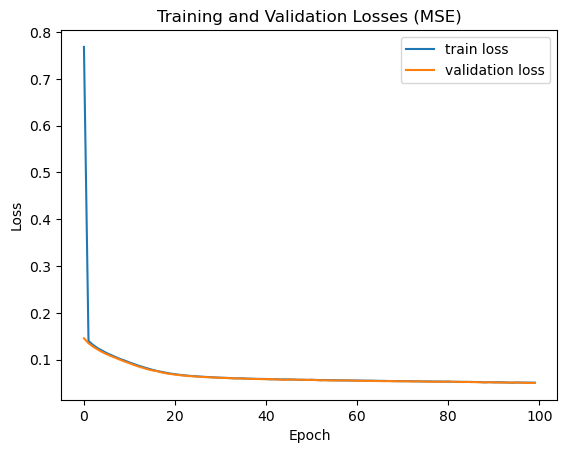

In [12]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses (MSE)")
plt.show()

##### Testing

In [13]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    # batch_y is the traversal_costs of a batch (32 sequences)
    for batch_x, batch_y in test_loader:
        # Move images and traversal scores to GPU (if available)
        batch_x = batch_x.to(device)
        batch_y = batch_y.type(torch.FloatTensor).to(device)
        #predicted_traversal_costs
        predicted_traversal_costs = model(batch_x.view(batch_size, seq_len, input_size))
        loss = nn.MSELoss()(predicted_traversal_costs.squeeze(), batch_y.float())
        test_loss += loss.item() * batch_x.size(0)
    
    # Compute the loss and accuracy
    test_loss /= len(test_loader.dataset)

print("Test loss: ", test_loss)    

Test loss:  0.06317524024971614


In [14]:

batch_idx, (batch_x, batch_y) in next(enumerate(iter(test_loader)))
batch_x = batch_x.to(device)
batch_y = batch_y.type(torch.FloatTensor).to(device)

     
output = model(batch_x.view(batch_size, seq_len, input_size))

print("Output:\n", output)
print("Ground truth:\n", batch_y)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)

Output:
 tensor([[1.5104],
        [1.4886],
        [1.5345],
        [1.5640],
        [1.5703],
        [1.5451],
        [1.5297],
        [1.5106],
        [1.5087],
        [1.5219],
        [1.5209],
        [1.4473],
        [1.5330],
        [1.4816],
        [1.5486],
        [1.4975]], device='cuda:0', grad_fn=<AddmmBackward0>)
Ground truth:
 tensor([1.0929, 1.1668, 0.9735, 0.9399, 1.4558, 1.2730, 1.2456, 1.0721, 1.1277,
        1.1630, 0.9662, 1.2295, 1.0661, 1.2375, 0.8714, 1.3905],
       device='cuda:0')


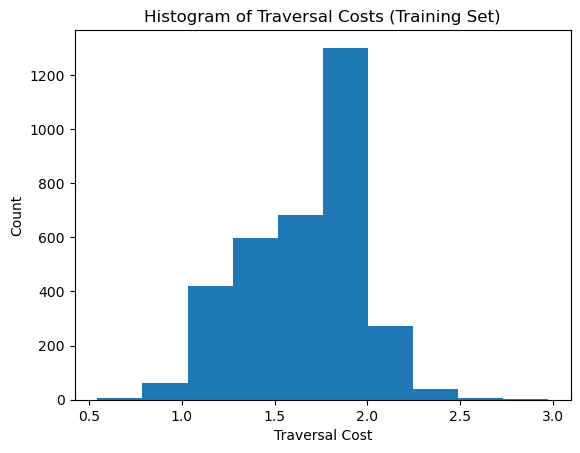

In [15]:
traversal_costs_train = []

for _, score in train_dataset:
    traversal_costs_train.append(score)
    
plt.hist(traversal_costs_train, bins=10)
plt.xlabel("Traversal Cost")
plt.ylabel("Count")
plt.title("Histogram of Traversal Costs (Training Set)")
plt.show()


In [17]:
# Save the model parameters
torch.save(model.state_dict(), "100_sequence_gru.params")